In [1]:
import numpy as np
import pandas as pd
import volpriceinference as vl
# import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from functools import partial

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [5]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.01,
               'scale': 252 * 1.564e-5,
               'delta': 0.6475,
               'rho': .95,
              }
else:
     true_params ={'delta': 0.27,
                   'rho': 0.81,
                   'scale': 3.11,
                   'phi': -.1,
                   'pi': -.2,
                   'theta': .53}
    
time_dim = 37000
sim_dim = 500
innov_dim = 250

In [6]:
vl.__version__

'0.0.13-py36_0'

In [7]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [8]:
def compute_moments(delta, rho, scale, phi, pi, theta):
    
    vol_mean = scale * delta / (1 - rho)
    vol_var = (2 * scale * rho * vol_mean + scale**2 * delta) / (1 - rho**2)
    
    psi = vl.compute_psi(rho=rho, scale=scale, phi=phi, theta=theta)
    beta = vl.compute_beta(rho=rho, scale=scale, phi=phi, pi=pi, theta=theta)
    gamma = vl.compute_gamma(delta=delta, rho=rho, scale=scale, phi=phi, pi=pi, theta=theta)
    
    return_mean = psi * vol_mean + beta * vol_mean + gamma
    return_var = psi**2 * vol_var + beta**2 * vol_var  + (1 - phi**2) * vol_mean
    
    return {'return_mean': return_mean, 'return_var': return_var, 'vol_mean': vol_mean, 'vol_var': vol_var}

In [9]:
compute_moments(**true_params)

{'return_mean': -0.06419485367329981,
 'return_var': 0.05877411795187698,
 'vol_mean': 0.051039575999999955,
 'vol_var': 0.004023225201945595}

In [10]:
vl.compute_gamma(**true_params)

0.0003040704223442014

In [11]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95,
 'gamma': 0.0003040704223442014,
 'beta': 0.11823710670185328,
 'psi': -1.3819412584691815,
 'zeta': 0.9999}

In [12]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95}

In [13]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95,
 'gamma': 0.0003040704223442014,
 'beta': 0.11823710670185328,
 'psi': -1.3819412584691815,
 'zeta': 0.9999}

## We start by examining the distributions of simulated data

In [14]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [15]:
data.corr()

,vol,rtn
vol,1.000000,-0.327604
rtn,-0.327604,1.000000


In [16]:
omega, omega_cov = vl.estimate_params(data)

In [17]:
omega

{'gamma': 0.00014975750689374953,
 'beta': 0.13351771846121938,
 'psi': -1.409623031761711,
 'zeta': 0.9924520325506445,
 'delta': 0.6157617748606046,
 'rho': 0.9460204375230948,
 'scale': 0.003958295988497757}

In [18]:
omega_cov

,beta,delta,gamma,psi,rho,scale,zeta
beta,0.001659,0.000000e+00,-4.233881e-06,-0.001566,0.000000e+00,0.000000e+00,0.000000
delta,0.000000,3.659706e-04,0.000000e+00,0.000000,-3.019355e-05,-1.135324e-07,0.000000
gamma,-0.000004,0.000000e+00,3.862597e-08,0.000003,0.000000e+00,0.000000e+00,0.000000
psi,-0.001566,0.000000e+00,3.379039e-06,0.002085,0.000000e+00,0.000000e+00,0.000000
rho,0.000000,-3.019355e-05,0.000000e+00,0.000000,7.217840e-06,-1.390133e-08,0.000000
scale,0.000000,-1.135324e-07,0.000000e+00,0.000000,-1.390133e-08,2.572768e-09,0.000000
zeta,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000054


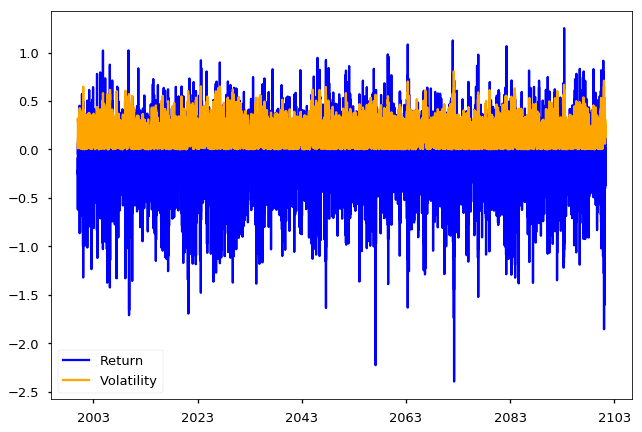

In [19]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [20]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.013851,-0.008148
rtn,-0.008148,0.050187


In [21]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'scale': 0.00394128,
 'delta': 0.6475,
 'rho': 0.95,
 'gamma': 0.0003040704223442014,
 'beta': 0.11823710670185328,
 'psi': -1.3819412584691815,
 'zeta': 0.9999}

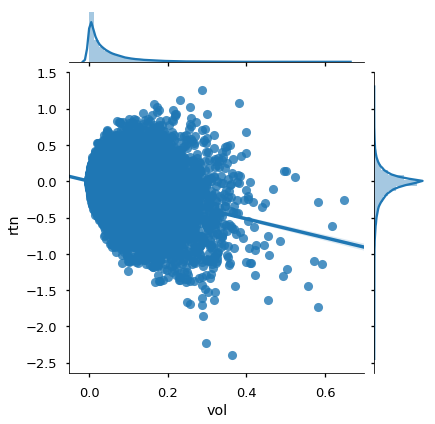

In [22]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [23]:
data.describe()

,vol,rtn
count,37000.000000,37000.000000
mean,0.045179,-0.057507
std,0.056455,0.224025
min,0.000010,-2.393818
25%,0.007154,-0.137451
50%,0.024478,-0.020574
75%,0.061570,0.048016
max,0.649158,1.251111


## I now estimate all of the parameters

In [ ]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [ ]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [ ]:
estimator(data_arr[2])

In [ ]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [ ]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [ ]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [ ]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in ['phi', 'pi', 'theta']:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([est[name] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.set_xlabel(name)
        ax.axvline(total_true_params[name], color='black')
        
        if name == 'pi':
            ax.set_xlim(-21, 1)
        
        fig.savefig('../doc/figures/{}_est_{}_{}.tmp.pdf'.format(name, sim_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)

# I now import  robust conditional QLR statistic 

In [47]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.json'.format(innov_dim, -0.4, 
                                                                         3700)
else:
    filename = '../results/reject_prop_{}_{}_{}.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)

In [48]:
filename

'../results/reject_prop_kharpov_250_-0.4_3700.json'

In [49]:
returnval = pd.read_json(filename)

In [50]:
pd.DataFrame(stats.chi2.cdf( returnval.qlr_stat, df=4) > .95).mean()

0    0.026
dtype: float64

In [51]:
returnval.query('robust_qlr_qauntile > 0').mean()

qlr_stat               3.179932
robust_qlr_qauntile    7.357117
robust                 0.076000
standard               0.062000
dtype: float64

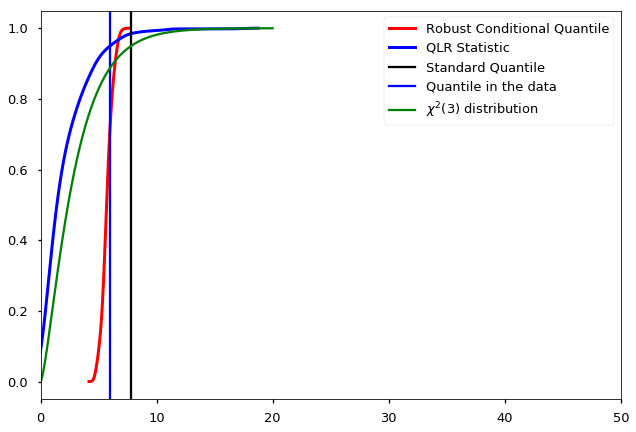

In [31]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)